In [1]:
%load_ext autoreload
%autoreload 2
%autoawait trio
%matplotlib inline

import trio
import pyfuse3
import src
import logging
import matplotlib
import matplotlib.pyplot as plt
import IPython

from src.runner import Runner
from src.mock_runner import MockRunner
from src.env import Env
from src.stats.post import *
from src.predicting import make_predictor
import src.methods
import pandas as pd
from pandas import read_csv
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_colwidth', 500)

In [88]:
import subprocess
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

def files_to_vec_df(in_paths, shouldPrefetch=None, components=2):
    cv = CountVectorizer(analyzer='char')
    X = cv.fit_transform(in_paths)
    svd = TruncatedSVD(n_components=components)
    x_svd = svd.fit_transform(X)
    dfn = DataFrame()
    dfn["filename"] = in_paths
    for xn in range(components):
        dfn["x" + str(xn)] = x_svd[:, xn]
    dfn["shouldPrefetch"] = shouldPrefetch
    return dfn

result = subprocess.run(['find', '.'], stdout=subprocess.PIPE)
all_files = result.stdout.decode().split()[1:]

re_lambda = lambda x: (re.match('.*\.py$', x) or re.match('.*Gmax', x)) and True or False

all_files_labels = list(map(re_lambda, all_files))
dfn = files_to_vec_df(all_files, all_files_labels)
dfn

,filename,x0,x1,shouldPrefetch
0,./soykb30min,2.056505,0.479618,False
1,./requirements.txt,3.205107,0.531122,False
2,./.gitignore,2.287406,0.373006,False
3,./workers_tests.yml,4.114429,-0.705780,False
4,./sources,2.190267,-0.528596,False
...,...,...,...,...
2877,./mcache/3f6e6221d5ec5c21.h5,3.784630,2.409263,False
2878,./mcache/4d52ede0eb3f97bc.h5,3.725981,2.280290,False
2879,./mcache/17d37230793e2736.h5,3.476818,2.873224,False
2880,./mock_df,1.627453,-0.555391,False


In [315]:
class Stride(Base):
    a: Read
    b: Read

    def __init__(self):
        self.a = None
        self.b = None

    def push(self, read):
        self.a = self.b
        self.b = read

    def _predict(self):
        if not self.a:
            return None
        
        if self.a.filename != self.b.filename:
            return None

        stride = self.a.offset - self.b.offset
        return self.b.replace(
            offset=self.b.offset - stride
        )


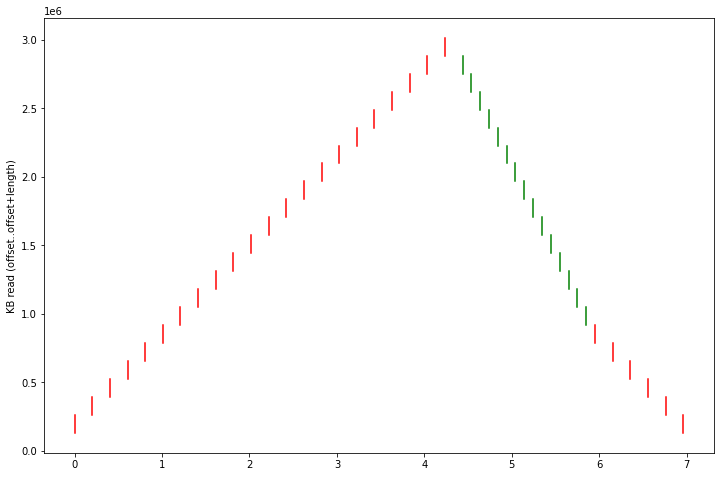

In [321]:
cattac_results = await Runner('demo', predictor=None).run()
draw_reads(cattac_results)

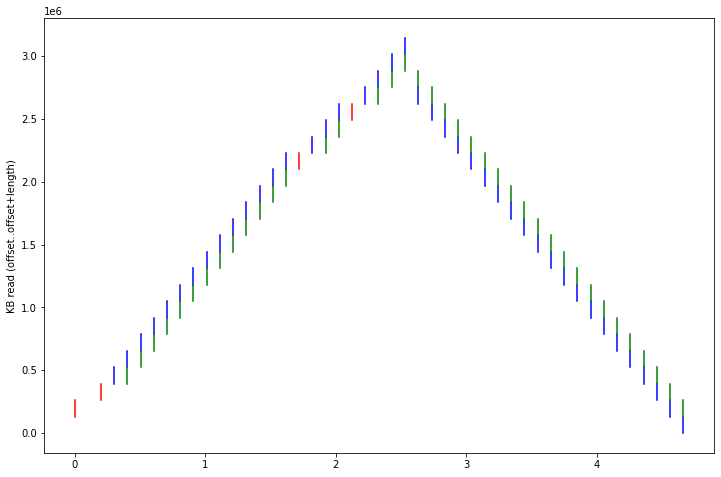

In [322]:
cattac_results = await Runner('demo', predictor=Stride).run()
draw_reads(cattac_results)

In [60]:
df_sk = read_csv('soykb30min')

pr = od.methods.dtc.Dtc(df=df_sk)
filenames
pr.fit(filenames)
env = Env('soykb').cache(float('inf'))

df_mock = MockRunner(predictor=pr, env=env).run(df_sk)

NameError: name 'filenames' is not defined

In [6]:
df = await Runner('soykb').run(timeout=30*60)

2021-04-30 04:35:00.131 MainThread: [od.runner] No predictor set
2021-04-30 04:35:00.400 MainThread: [run] running cmd: docker run -a stdout -a stderr --rm \
  --network container:redis \
  -e HF_VAR_WORKER_CONTAINER="hyperflowwms/soykb-worker" \
  -e HF_VAR_WORK_DIR="/wfdir/input" \
  -e HF_VAR_HFLOW_IN_CONTAINER="true" \
  -e HF_VAR_function="redisCommand" \
  -e REDIS_URL="redis://127.0.0.1:6379" \
  --name hflow_soykb \
  -v /var/run/docker.sock:/var/run/docker.sock \
  -v /home/brt/h/mgr/target:/wfdir \
  --entrypoint "/bin/sh" \
  hflow -c "hflow run /wfdir" \
  && echo 'KONIEC' \
  && exit 0


would raise [Errno 1] Operation not permitted: './sources/soykb/input/logs-hf'
would raise [Errno 1] Operation not permitted: './sources/soykb/input/CSPI.1341628845728897699.tmp'


--- Logging error ---
Traceback (most recent call last):
  File "/home/brt/h/mgr/od/low_level_runner.py", line 75, in run_program
    status = await process.wait()
  File "/home/brt/.asdf/installs/python/miniconda3-latest/lib/python3.8/site-packages/trio/_subprocess.py", line 219, in wait
    await trio.lowlevel.wait_readable(self._pidfd)
  File "/home/brt/.asdf/installs/python/miniconda3-latest/lib/python3.8/site-packages/trio/_core/_generated_io_epoll.py", line 14, in wait_readable
    return await GLOBAL_RUN_CONTEXT.runner.io_manager.wait_readable(fd)
  File "/home/brt/.asdf/installs/python/miniconda3-latest/lib/python3.8/site-packages/trio/_core/_io_epoll.py", line 299, in wait_readable
    await self._epoll_wait(fd, "read_task")
  File "/home/brt/.asdf/installs/python/miniconda3-latest/lib/python3.8/site-packages/trio/_core/_io_epoll.py", line 295, in _epoll_wait
    await _core.wait_task_rescheduled(abort)
  File "/home/brt/.asdf/installs/python/miniconda3-latest/lib/python3.8/si

In [7]:
df.to_csv('soykb30min')

In [8]:
df

,end,filename,kind,length,offset,pid,timestamp
0,51.404297,./sources/soykb/workflow.json,Miss,52638.0,0.000000,234538.0,0.000000
1,955561.871094,./sources/soykb/input/Gmax_275_v2.0.fa.bwt,Miss,380.0,955561.500000,234602.0,1.911958
2,0.500000,./sources/soykb/input/Gmax_275_v2.0.fa.bwt,Miss,512.0,0.000000,234602.0,1.916361
3,1024.023438,./sources/soykb/input/Gmax_275_v2.0.fa.bwt,Miss,1048088.0,0.500000,234602.0,1.921081
4,2048.023438,./sources/soykb/input/Gmax_275_v2.0.fa.bwt,Miss,1048576.0,1024.023438,234602.0,1.929564
...,...,...,...,...,...,...,...
82272,451279.635742,./sources/soykb/input/Gmax_275_v2.0.fa,Miss,131072.0,451151.635742,248522.0,1797.561050
82273,451407.635742,./sources/soykb/input/Gmax_275_v2.0.fa,Miss,131072.0,451279.635742,248522.0,1797.574653
82274,451535.635742,./sources/soykb/input/Gmax_275_v2.0.fa,Miss,131072.0,451407.635742,248522.0,1797.593539
82275,451663.635742,./sources/soykb/input/Gmax_275_v2.0.fa,Miss,131072.0,451535.635742,248522.0,1797.612694


In [83]:
def seqc(seq):
    last = None
    count = 0
    counts = []
    for item in seq:
        if item != last:
            counts.append([last, count])
            count = 1
            last = item
        else:
            count += 1
        
    counts.append([last, count])
    return counts

q = DataFrame(seqc(list(df.pid)))
q[0:150]

,0,1
0,NaN,0
1,103133.0,1
2,103194.0,2334
3,103300.0,3
4,103411.0,185
5,103514.0,9
6,103612.0,46
7,103646.0,4
8,103612.0,5
9,103646.0,1


In [84]:
len(set(df.pid))

145

In [85]:
def seqc(seq):
    last = None
    count = 0
    counts = []
    for item in seq:
        if item != last:
            counts.append([last, count])
            count = 1
            last = item
        else:
            count += 1
        
    counts.append([last, count])
    return counts

pids = set(df.pid)
for pid in pids:
    q = DataFrame(seqc(list(df[df.pid == pid].filename)))
    print(pid, "\n", q, "\n")

108035.0 
                                               0  1
0                                          None  0
1  ./sources/soykb/input/gatk-output.XXXXKAEAcK  3 

106003.0 
                                                              0   1
0                                                         None   0
1      ./sources/soykb/input/20180321-083514-USB-001_Chr12.vcf   5
2                   ./sources/soykb/input/Gmax_275_v2.0.fa.fai   8
3                     ./sources/soykb/input/Gmax_275_v2.0.dict  19
4  ./sources/soykb/input/20180321-083514-USB-001_Chr12.vcf.idx   2 

109077.0 
                                                       0  1
0                                                  None  0
1  ./sources/soykb/input/20180321-083514-GVCF_Chr01.vcf  5
2  ./sources/soykb/input/20180321-083514-GVCF_Chr02.vcf  5
3  ./sources/soykb/input/20180321-083514-GVCF_Chr03.vcf  5
4  ./sources/soykb/input/20180321-083514-GVCF_Chr04.vcf  5 

106531.0 
                                          

In [54]:
df

,end,filename,kind,length,offset,pid,timestamp
0,51.404297,./sources/soykb/workflow.json,Miss,52638.0,0.000000,83029.0,0.000000
1,955561.871094,./sources/soykb/input/Gmax_275_v2.0.fa.bwt,Miss,380.0,955561.500000,83092.0,2.273264
2,0.500000,./sources/soykb/input/Gmax_275_v2.0.fa.bwt,Miss,512.0,0.000000,83092.0,2.278181
3,1024.023438,./sources/soykb/input/Gmax_275_v2.0.fa.bwt,Miss,1048088.0,0.500000,83092.0,2.282835
4,2048.023438,./sources/soykb/input/Gmax_275_v2.0.fa.bwt,Miss,1048576.0,1024.023438,83092.0,2.292586
...,...,...,...,...,...,...,...
4580,251756.008789,./sources/soykb/input/Gmax_275_v2.0.fa,Miss,131072.0,251628.008789,83535.0,58.727015
4581,251884.008789,./sources/soykb/input/Gmax_275_v2.0.fa,Miss,131072.0,251756.008789,83535.0,58.736835
4582,252012.008789,./sources/soykb/input/Gmax_275_v2.0.fa,Miss,131072.0,251884.008789,83535.0,58.746787
4583,252140.008789,./sources/soykb/input/Gmax_275_v2.0.fa,Miss,131072.0,252012.008789,83535.0,58.756650


In [33]:
df.to_csv('soykb')

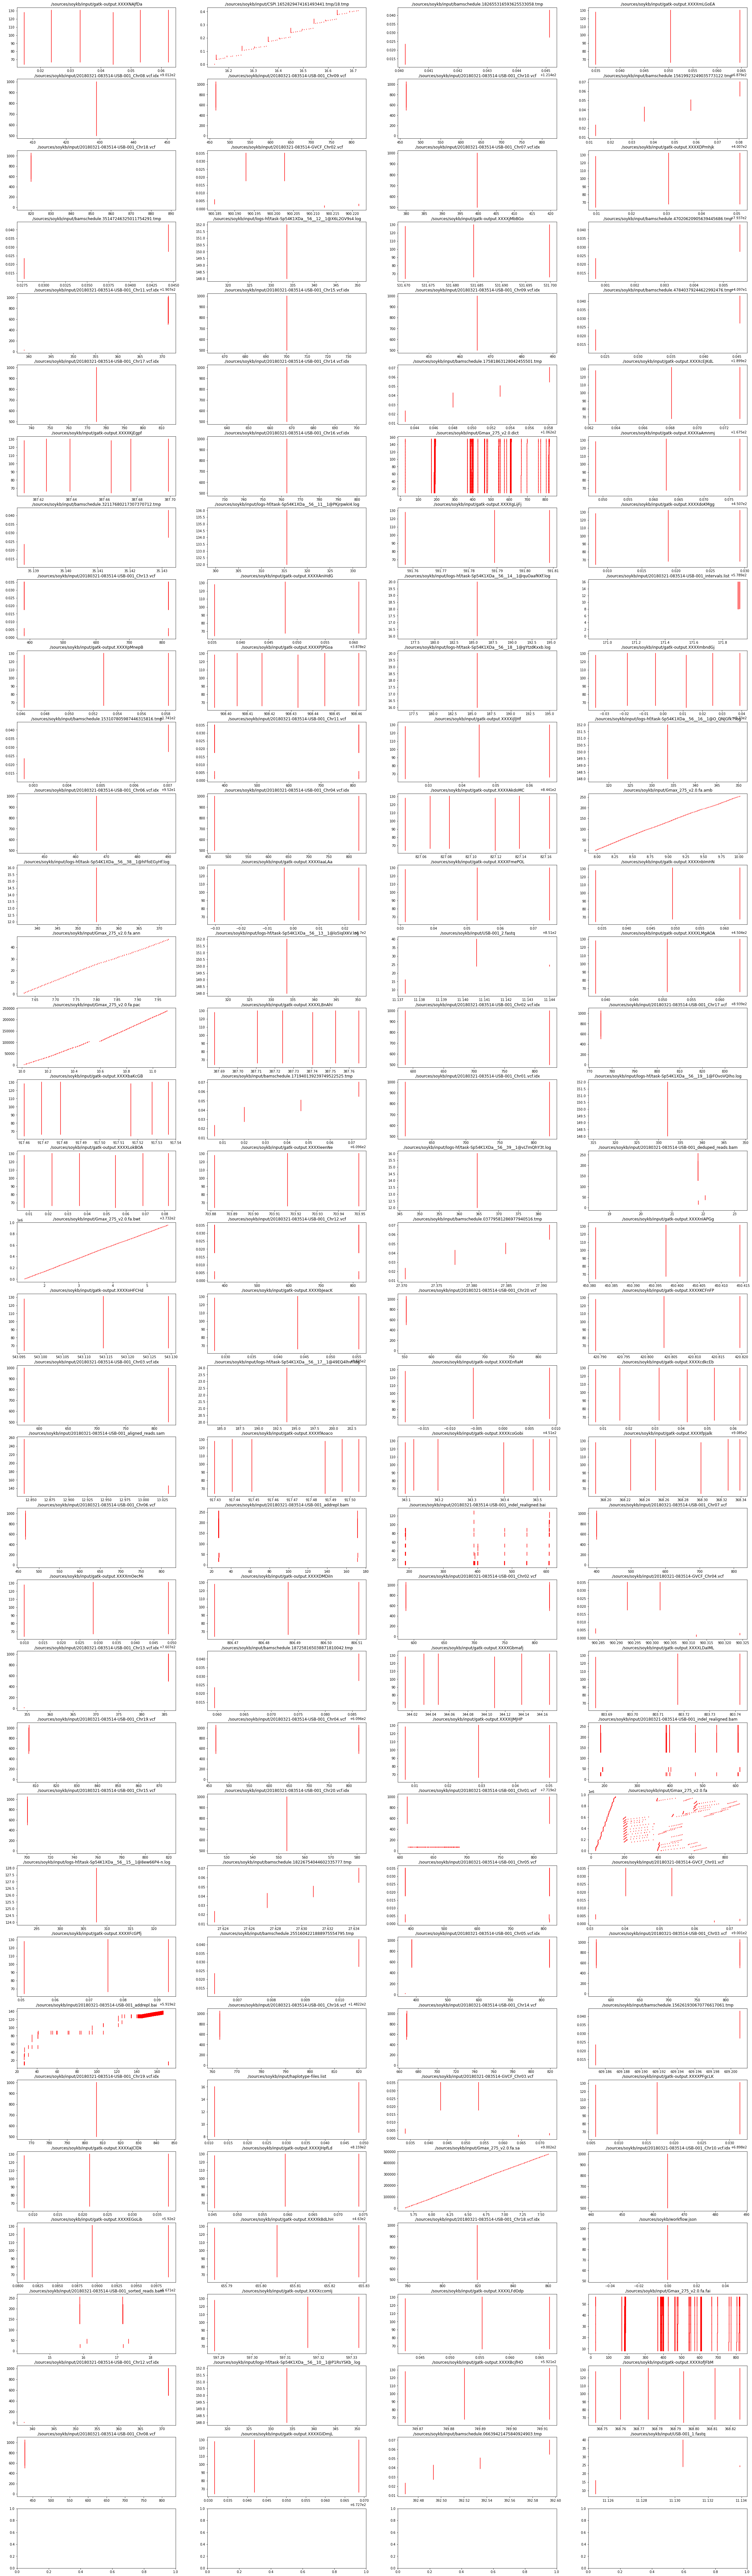

In [48]:
%matplotlib inline
draw_reads_all_files(df)

In [87]:
draw_reads(df, figsize=(12, 8))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [137]:
df = await Runner('many_files').run()
df.to_csv('df')

2021-04-12 09:25:45.480 MainThread: [od.runner] No predictor set
2021-04-12 09:25:45.802 MainThread: [run] running cmd: python workers/many.py --filedir target/ --filecount 50 --group_count 5 --group_len 10 --seq_count 10 --seq_len 10 --seq_repeats 16 --file_repeats 64
2021-04-12 09:25:56.352 MainThread: [run] Duration: 10.545703411102295
2021-04-12 09:25:56.353 MainThread: [run] Output: 
''


In [70]:
df1 = await Runner('shared_sequences_one_group').run()
df1.to_csv('shared_sequences_one_group')
df5 = await Runner('shared_sequences_five_groups').run()
df5.to_csv('shared_sequences_five_groups')

2021-04-19 10:24:23.340 MainThread: [od.runner] No predictor set
2021-04-19 10:24:23.594 MainThread: [run] running cmd: python workers/many.py --filedir target/ --filecount 50 --group_count 1 --group_len 50 --seq_count 50 --seq_len 10 --seq_repeats 16 --file_repeats 40
2021-04-19 10:29:27.061 MainThread: [run] Duration: 303.4642825126648
2021-04-19 10:29:27.062 MainThread: [run] Output: 
''
2021-04-19 10:29:27.063 MainThread: [run] Closed
2021-04-19 10:29:27.398 MainThread: [od.runner] No predictor set
2021-04-19 10:29:27.651 MainThread: [run] running cmd: python workers/many.py --filedir target/ --filecount 50 --group_count 5 --group_len 10 --seq_count 10 --seq_len 10 --seq_repeats 16 --file_repeats 40
2021-04-19 10:34:59.545 MainThread: [run] Duration: 331.8917133808136
2021-04-19 10:34:59.546 MainThread: [run] Output: 
''
2021-04-19 10:34:59.547 MainThread: [run] Closed


In [71]:
len(df1), len(df5)

(64000, 64000)

In [126]:
demo = Env('soykb')
demo.data['ping'] = 30
demo.capacity = 8192*4
prd = Predictor('ss', demo)

runner = Runner('./workers/pp_seq2.py ./target/50mb 128 8 16', demo, prd, timeout=100, debug=False)
operations = await runner.start()
df = make_df(operations)
draw_reads(df)

TypeError: __init__() takes 2 positional arguments but 3 were given

In [3]:
from src.methods.lstm import Lstm1 as NN
nn = NN()
df = df[df.kind != 'Prefetch']
(X, Y) = nn.transform_data(df)
nn.run(X, Y, X, Y, params={ "epochs": 60, 'hidden_neurons': 400 }, verbose=1)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc (InputLayer)                [(None, None, 96)]   0                                            
__________________________________________________________________________________________________
dec (InputLayer)                [(None, None, 96)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 400), (None, 795200      enc[0][0]                        
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 400),  795200      dec[0][0]                        
                                                                 lstm[0][1]                   

In [4]:
demo = Env()
demo.capacity = 8192*64
demo.data['ping'] = 1
prd = Predictor('lstm', demo)
prd.p = nn

runner = Runner('./workers/pp_seq2.py ./target/50mb 128 8 16', demo, prd, timeout=300, debug=False)
result = await runner.start()
df = make_df(result)
draw_reads(df)
read_stats(df)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

          filename  offset  length   end  timestamp
kind                                               
Hit            489     489     489   489        489
Miss           535     535     535   535        535
Prefetch      1010    1010    1010  1010       1010


In [3]:
df = read_csv('traces/wf1')

In [5]:
df

,Unnamed: 0,kind,filename,timestamp,offset,length,real_length,hit,pid,source,fingerprint
0,0,Miss,./sources/soykb/workflow.json,0.000000,0,16777216,52638,False,323201,read,NaN
1,1,Miss,./sources/soykb/input/Gmax_275_v2.0.fa.bwt,1.274438,973078528,16777216,380,False,323272,read,NaN
2,2,Miss,./sources/soykb/input/Gmax_275_v2.0.fa.bwt,1.274825,0,16777216,512,False,323272,read,NaN
3,3,Miss,./sources/soykb/input/Gmax_275_v2.0.fa.bwt,1.299563,16777216,16777216,512,False,323272,read,NaN
4,4,Miss,./sources/soykb/input/Gmax_275_v2.0.fa.bwt,1.323090,33554432,16777216,512,False,323272,read,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4769,4769,Hit,./sources/soykb/input/gatk-output.XXXXGHibOP,560.328527,0,16777216,2090,True,334740,read,NaN
4770,4770,Miss,./sources/soykb/input/gatk-output.XXXXEnLoHo,565.959375,0,16777216,2203,False,334958,read,NaN
4771,4771,Miss,./sources/soykb/input/gatk-output.XXXXklgAHJ,565.959469,0,16777216,2210,False,334959,read,NaN
4772,4772,Hit,./sources/soykb/input/gatk-output.XXXXklgAHJ,565.963458,0,16777216,2210,True,334963,read,NaN


In [6]:
df3 = read_csv('soykb30min')

In [10]:
len(set(df3.filename))

4441